# In this notebook we will present all the results and then choose

\begin{itemize}
    \item Pure data analysis section. where we check curvature i guess. (Anything else?) We could look at a histogram of points in 1D, but how useful would that be?
    \item Section with a table. 
    \item Section 2D visulization. Also 1D visulization. These should be modifiable that i just give it some data and then it's presented. This is because i could just    span some subspace in any dimension and then look how well it interpolates. 
\end{itemize}

In [6]:
import sys, os
import ujson as json
from pathlib import Path 
HOME = "/rds/general/user/dl2119/home/ICLR_Interp" # Path(os.environ["PATH_INTP_FOLDER"])
os.environ["PATH_INTP_FOLDER"] = HOME
HOME = Path(HOME)
sys.path.append(str(HOME))
sys.path.append(str(HOME / "DataGeneration"))
sys.path.append(str(HOME / "ModelGeneration"))
sys.path.append(str(HOME / "ModelGeneration" / "DelaunaySparse"))
sys.path.append(str(HOME / "ModelComparison"))


import pandas as pd 
import jax.random as jrandom
from scipy.interpolate import RBFInterpolator
import jax.numpy as jnp
import numpy as np

from GModel import GModel
from ModelComparison import get_rbf_tags
from save_load_data import load_fast, get_all_data_configurations
from save_load_model import save_nn, get_all_net_tags
from save_load_comps import load_all_comps
from nn_train import train
from DataAnalysis import curv

from vis_utils import get_line_along_v, get_constrained_plane_along_uv




import torch
import torchvision
import torch.optim as optim
from torch import Tensor

import torch.nn as nn
from torch.nn import Module

from torch.utils.data import DataLoader

import matplotlib.pyplot as plt 

from Functions import get_func
import numpy as np

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Visualization

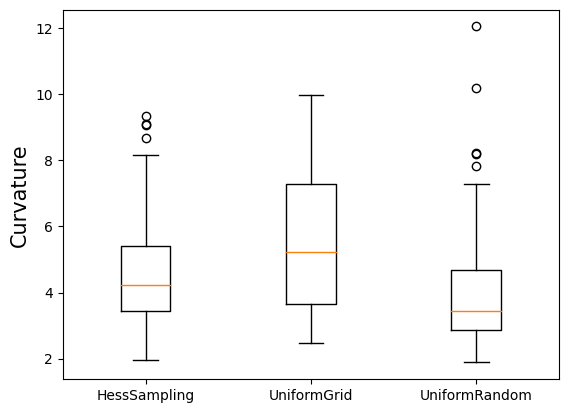

In [41]:
def compute_hess_trace_stat(func, dim, N):
    res = {}
    for data_gen_method in ["HessSampling", "UniformGrid", "UniformRandom"]:
        X_data, y_data = load_fast(func, dim, N, data_gen_method)
        F = get_func(func)
        res[data_gen_method] = np.array(curv(F, X_data))

    fig, ax = plt.subplots()
    ax.boxplot(res.values())
    ax.set_ylabel('Curvature', fontsize=15)
    ax.set_xticklabels(res.keys())
    plt.show()
    
func = "Ackley"
dim = 4
N = 100
compute_hess_trace_stat(func, dim, N)

AttributeError: 'NoneType' object has no attribute 'shape'

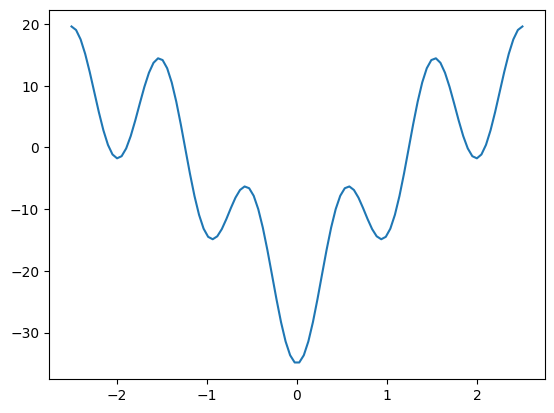

In [7]:
from DataAnalysis import curv    
import plotly.graph_objects as go

def compute_hess_trace_stat(func, dim, N):
    for data_gen_method in ["HessSampling", "UniformGrid", "UniformRandom"]:
        X_data, y_data = load_fast(func, dim, N, data_gen_method)
        F = get_func(func)
        curv_vals = np.array(curv(F, X_data))
        plt.boxplot(curv_vals)
        
    plt.show()
    

    
# For each data, I want to visualize the curvature hist. 
# For each data, I want to visualize 1 and 2D locations. Option toggle to overlay the real data with lower opacity
def hess_trace_visualization(func, dim, N, data_gen_method):
    X_data, y_data = load_fast(func, dim, N, data_gen_method)
    
    F = get_func(func)
    curv_vals = np.array(curv(F, X_data))
    plt.hist(curv_vals)
    
    plt.show()
    
def loc_vis(func, dim, N, data_gen_method, N_vis):
    assert dim <= 2
    
    X_data, y_data = load_fast(func, dim, N, data_gen_method)
    F = get_func(func)
    
    if dim == 1:
        x_vis = np.linspace(F.bounds[0][0], F.bounds[0][1], N_vis).reshape(-1, 1)
        F_vis = F.f(x_vis)
#         hess_trace_vis = curv(F, x_vis)
        
#         hess_trace_data = curv(F, X_data)
        
        # F vis
        plt.plot(x_vis, F_vis)
        print(y_data.shape)
        plt.scatter(X_data, y_data)
        plt.show()
        
#         # Hess vis
#         plt.plot(x_vis, hess_trace_vis)
#         plt.scatter(X_data, hess_trace_data)
#         plt.show()
        
    else:
        x_vis = np.linspace(F.bounds[0][0], F.bounds[0][1], N_vis).reshape(-1, 1)
        XY = np.meshgrid(x_vis, x_vis)
        pts = np.array([XY[0].ravel(), XY[1].ravel()]).T
        
        F_vis = F.f(pts)
        hess_trace_vis = curv(F, pts)
        hess_trace_data = curv(F, X_data)
        
        # F vis
        fig = go.Figure(data=[go.Mesh3d(x = pts[:, 0], y = pts[:, 1], z = F_vis, opacity=1),
                                go.Scatter3d(x=X_data[:, 0], y=X_data[:, 1], z=y_data, mode='markers')
        ])
        fig.update_layout(scene = dict(
                    xaxis_title='x',
                    yaxis_title='y',
                    zaxis_title='Function value'))
        camera = dict(
        eye=dict(x=2, y=2, z=0.1)
        )

        fig.update_layout(scene_camera=camera, width =1000, height=1000)
        fig.show()
        
        # Hess vis
        #fig = go.Figure(data=[go.Mesh3d(x = pts[:, 0], y = pts[:, 1], z = hess_trace_vis, opacity = 0.5),
        #                        go.Scatter3d(x=X_data[:, 0], y=X_data[:, 1], z=hess_trace_data, mode='markers')
        #])
#         fig = go.Figure(data=[go.Contour(x = pts[:, 0], y = pts[:, 1], z = hess_trace_vis, \
#                                          colorscale='gnbu', contours_coloring='heatmap', \
#                                          line_width=0), go.Scatter(x=X_data[:, 0], y=X_data[:, 1], mode='markers', \
#                                         marker=dict(color='LavenderBlush',size=10,line=dict(width=1,
#                                         color='DarkSlateGrey')))\
#                                          ])
#         fig.update_layout(width=500)
#         fig.show()
        
        
        


        
func = "Rasti"
dim = 1
N = 20
data_gen_method = "Reparam_{}_useNorm_{}".format("curv", "False")
N_vis = 100
loc_vis(func, dim, N, data_gen_method, N_vis)
# loc_vis(func, dim, N, "HessSampling", N_vis)




AttributeError: 'NoneType' object has no attribute 'shape'

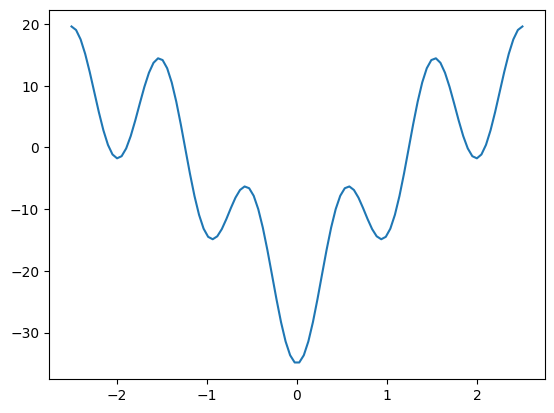

In [8]:
        
func = "Rasti"
dim = 1
N = 10
data_gen_method = "Reparam_{}_useNorm_{}".format("curv", "False")
N_vis = 100
loc_vis(func, dim, N, data_gen_method, N_vis)
# loc_vis(func, dim, N, "HessSampling", N_vis)




In [27]:
func = "Michi"
dim = 3
N = 100
data_gen_method = "HessSampling"

hess_trace_visualization(func, dim, N, data_gen_method)
hess_trace_visualization(func, dim, N, "UniformRandom")

NameError: name 'hess_trace_visualization' is not defined

# Trained Model Visualization

In [9]:
from torch import Tensor
from chart_studio import plotly as py
import plotly.graph_objs as go

def visualize_1d(func_name, dim, N, data_gen_method, model_tag, v, N_param):
    X_train, y_train = load_fast(func_name, dim, N, data_gen_method)

    model = GModel(func_name, dim, N, data_gen_method, tag)
    F = get_func(func_name)
    vs = get_line_along_v(F, v, N_param)
    z_model = model.f(vs)
    z_true = F.f(vs)
    plt.plot(vs, z_model, label="model")
    plt.plot(vs, z_true, label="true")
    plt.scatter(X_train, y_train, label="Train points")
    plt.legend()
    plt.show()
    
def visualize_2d(func_name, dim, N, data_gen_method, model_tag, u, v, N_param):
    model = GModel(func_name, dim, N, data_gen_method, tag)
    F = get_func(func_name)
    prmtrztn, pts = get_constrained_plane_along_uv(F, u, v, N_param)    
    
    z_model = model.f(pts)
    z_true = F.f(pts)
    
    
    fig = go.Figure(data=[go.Mesh3d(x = prmtrztn[0], y = prmtrztn[1], z = z_model, opacity=0.7, name="model"),
                         go.Mesh3d(x = prmtrztn[0], y = prmtrztn[1], z = z_true, opacity=0.2, name="true")])
    
#     fig.update_layout(showlegend=True)
    fig.show()
    

In [10]:

func_name = "Dixon"
dim = 2
N = 12**dim
data_gen_method = "UniformGrid"
# tag = "nn_depth_4_width_8_opt_Adam_lr_0.001_bs_16_l2p_0" # get_all_net_tags(func_name, dim, N, data_gen_method)[0]

tag = "rbf_{}_neighbors_1000.0".format("thin_plate_spline")
tag = "linear"

# SEE HERE FOR WHICH TAGS ARE AVAILABLE
available_nn_tags = get_all_net_tags(func_name, dim, N, data_gen_method)
available_rbf_tags = get_rbf_tags()
# tag = available_rbf_tags[0]
print(tag)

N_param = 100
v = np.eye(dim)[0]
u = np.eye(2)[1]
# v = np.random.normal(size=(dim))
# v /= np.linalg.norm(v)
# u = np.random.normal(size=(dim))
# u /= np.linalg.norm(u)

linear


In [12]:
N = 8
# tag = "rbf_thin_plate_spline_neighbors_1000.0"
tag = "rbf_gaussian_neighbors_1000.0_eps_1"

tag = "linear"
visualize_2d(func_name, dim, N, "Reparam_curv_useNorm_True", tag, u, v, N_param)
visualize_2d(func_name, dim, N, "UniformGrid", tag, u, v, N_param)
visualize_2d(func_name, dim, N, "UniformRandom", tag, u, v, N_param)



# visualize_2d(func_name, dim, N, data_gen_method, tag, u, v, N_param)
# visualize_2d(func_name, dim, N, "MeshSimplify", tag, u, v, N_param)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

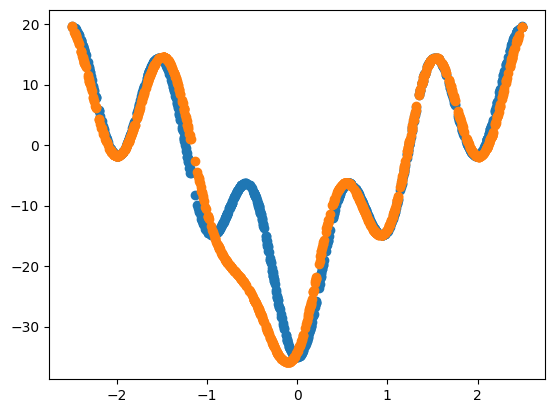

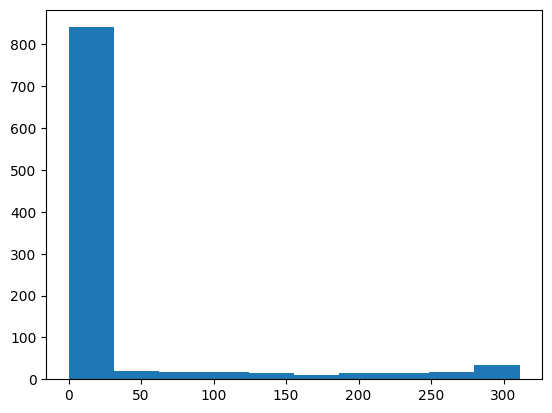

3.1463332439634204


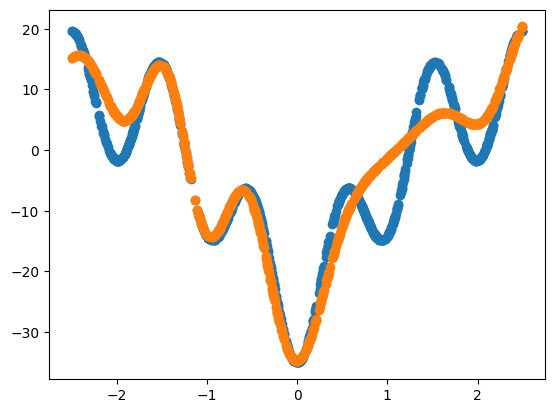

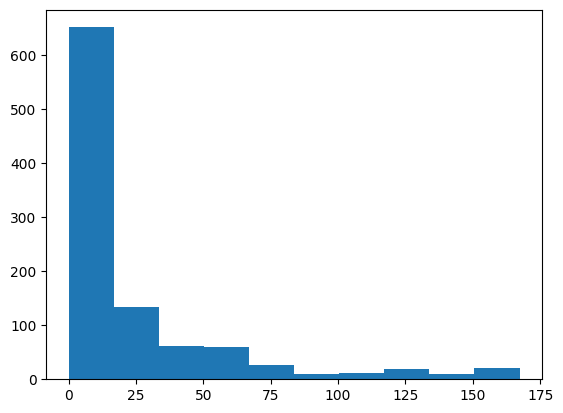

3.344901163327608


In [38]:
F = get_func(func_name)
N_test = int(1e3)
seed_test = 1
jrandom_key = jrandom.PRNGKey(seed_test)

X_test = np.array(jrandom.uniform(jrandom_key, minval=F.bounds[:, 0], maxval=F.bounds[:, 1],shape=(N_test, dim)))
y_test = np.array(F.f(X_test))


data_gen_method = "Reparam_curv_useNorm_True"
X_train, y_train = load_fast(func_name, dim, N, data_gen_method)
model = GModel(func_name, dim, N, data_gen_method, tag)

test_out = model.f(X_test)
test_errs = (y_test.flatten() - test_out.flatten())**2
test_mean_err = np.mean(test_errs)
plt.scatter(X_test, y_test)
plt.scatter(X_test, test_out)
plt.show()
plt.hist(test_errs)
plt.show()
print(np.mean(np.abs((y_test.flatten() - test_out.flatten()))))

data_gen_method = "UniformRandom"
X_train, y_train = load_fast(func_name, dim, N, data_gen_method)
model = GModel(func_name, dim, N, data_gen_method, tag)

test_out = model.f(X_test)
test_errs = (y_test.flatten() - test_out.flatten())**2
test_mean_err = np.mean(test_errs)
plt.scatter(X_test, y_test)
plt.scatter(X_test, test_out)
plt.show()
plt.hist(test_errs)
plt.show()
print(np.mean(np.abs((y_test.flatten() - test_out.flatten()))))

# Trained Model Comps

In [2]:
df = load_all_comps()

In [1]:
df['N']
df

NameError: name 'df' is not defined

In [53]:
df[(df["dim"] == 1) & (df["N"] == 10) & (df["model"] == "nn") & (df["func_name"] == "Dixon")].sort_values(by=['trainLoss'])





,func_name,dim,N,data_gen_method,model,depth,width,opt,lr,bs,l2p,testLoss,trainLoss,momentum,kernel,neighbors,eps
34732,Dixon,1,10,Reparam_curv_useNorm_True,nn,4,16,Adam,0.001,4,0,13.671512,0.000235,0,0,0,0
34851,Dixon,1,10,Reparam_curv_useNorm_True,nn,4,16,Adam,0.001,4,0.001,11.035008,0.000390,0,0,0,0
34612,Dixon,1,10,Reparam_curv_useNorm_True,nn,4,16,SGD,0.01,4,0,37.947925,0.000769,0.9,0,0,0
34360,Dixon,1,10,Reparam_curv_useNorm_True,nn,4,16,SGD,0.01,4,0,37.947925,0.000769,0.0,0,0,0
34414,Dixon,1,10,Reparam_curv_useNorm_True,nn,4,16,SGD,0.01,4,0.001,31.079690,0.001374,0.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34630,Dixon,1,10,Reparam_curv_useNorm_True,nn,2,2,Adam,1e-05,64,1,188.707364,338.708942,0,0,0,0
34681,Dixon,1,10,Reparam_curv_useNorm_True,nn,2,2,SGD,1e-05,64,1,217.611349,348.106432,0.9,0,0,0
34254,Dixon,1,10,Reparam_curv_useNorm_True,nn,2,2,SGD,1e-05,64,1,217.611349,348.106432,0.0,0,0,0
34919,Dixon,1,10,Reparam_curv_useNorm_True,nn,2,2,Adam,1e-05,16,0,218.764320,351.782157,0,0,0,0


In [46]:
subset_df = df.groupby(by=["func_name", "dim", "N", "model", "kernel", "data_gen_method"]).apply(lambda x: x["testLoss"].min())


In [47]:
subset_df["Dixon"][40:100]

dim  N   model   kernel    data_gen_method          
1    8   rbf     linear    UniformGrid                   0.143528
                           UniformRandom                22.553108
                 thin      Reparam_curv_useNorm_True     5.239591
                           UniformGrid                   0.045512
                           UniformRandom                10.124470
     10  linear  0         Reparam_curv_useNorm_True     9.510787
                           UniformGrid                   0.049436
                           UniformRandom                 0.238403
         nn      0         Reparam_curv_useNorm_True     2.874123
                           UniformGrid                   0.028606
                           UniformRandom                 0.078767
         rbf     gaussian  Reparam_curv_useNorm_True     7.141342
                           UniformGrid                   0.443134
                           UniformRandom                 3.558690
                 linear

In [14]:
subset_df = df.groupby(by=["func_name", "dim", "N"]).apply(lambda x: x["data_gen_method"].iloc[x["testLoss"].argmin()])
# subset_df[subset_df.values == "nn"]
subset_df


func_name  dim  N   
Dixon      1    4                     UniformGrid
                6                     UniformGrid
                8                     UniformGrid
                10                    UniformGrid
                12                    UniformGrid
                16                    UniformGrid
                20                    UniformGrid
                40                    UniformGrid
           2    16                   MeshSimplify
                36                   MeshSimplify
                64                    UniformGrid
                100                   UniformGrid
                144                   UniformGrid
                256                   UniformGrid
                400                   UniformGrid
                1600                  UniformGrid
Michi      1    4                     UniformGrid
                6       Reparam_curv_useNorm_True
                8                     UniformGrid
                10           

In [37]:
subset_df = df.groupby(by=["func_name", "dim", "N", "data_gen_method"]).apply(lambda x: x["testLoss"].min())
subset_df

func_name  dim  N     data_gen_method          
Dixon      1    4     Reparam_curv_useNorm_True    5.126696e+00
                      UniformGrid                  1.510559e+00
                      UniformRandom                2.655024e+01
                6     Reparam_curv_useNorm_True    4.047529e+00
                      UniformGrid                  1.876817e-01
                                                       ...     
Rasti      2    400   UniformGrid                  3.534121e-02
                      UniformRandom                1.142466e-01
                1600  MeshSimplify                 1.066995e-04
                      UniformGrid                  5.907721e-09
                      UniformRandom                8.867139e-06
Length: 143, dtype: float64

(array([18.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  4.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

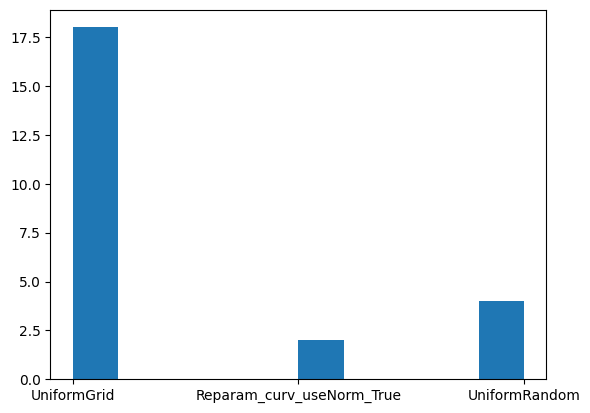

In [10]:
subset_df = df[df["dim"] == 1].groupby(by=["func_name", "dim", "N"]).apply(lambda x: x["data_gen_method"].iloc[x["testLoss"].argmin()])
plt.hist(subset_df.values)



(array([35.,  0.,  0.,  8.,  0.,  0.,  2.,  0.,  0.,  3.]),
 array([0. , 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3. ]),
 <BarContainer object of 10 artists>)

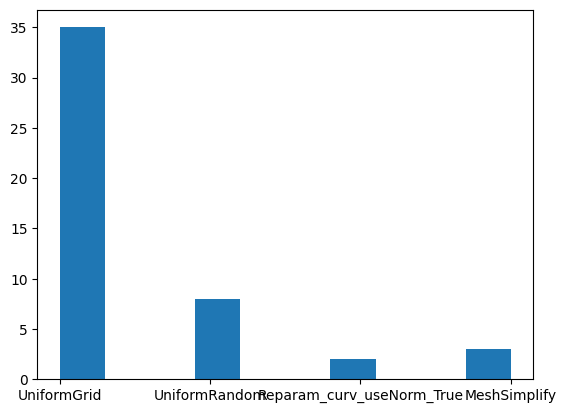

In [11]:
subset_df = df[df["model"] == "rbf"].groupby(by=["func_name", "dim", "N"]).apply(lambda x: x["data_gen_method"].iloc[x["testLoss"].argmin()])
plt.hist(subset_df.values)




In [67]:
import jax.random as jrandom

N_test = int(1e3)
seed_test = 1
jrandom_key = jrandom.PRNGKey(seed_test)

In [78]:

func_name = "Rosenbrock"
dim = 6
N = 1000
data_gen_method = "UniformRandom"

F = get_func(func_name)
X_test = np.array(jrandom.uniform(jrandom_key, minval=F.bounds[:, 0], maxval=F.bounds[:, 1],shape=(N_test, dim)))
y_test = np.array(F.f(X_test))
X_train, y_train = load_fast(func_name, dim, N, data_gen_method)

In [79]:

def compute_loss(model, X_train, y_train, X_test, y_test):

    test_out = model.f(X_test)
    test_errs = (y_test - test_out)**2
    test_mean_err = np.mean(test_errs)

    res = {"test_mean_err": float(test_mean_err) } #, "test_errs": test_errs.tolist(), }

    if model.tag_dict['model'] == "nn":
        train_out = model.f(X_train)
        train_errs = (y_train - train_out)**2
        train_mean_err = np.mean(train_errs)
        res["train_errs"] = train_errs.tolist()
        res["train_mean_err"] = float(train_mean_err)

    return res

def rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test): 
    res = {}

#     for rbf_tag in get_rbf_tags():
    rbf_tag = 'rbf_linear_neighbors_1000.0'
    rbf_model = GModel(func_name, dim, N, data_gen_method, rbf_tag)
    res[rbf_tag] = compute_loss(rbf_model, X_train, y_train, X_test, y_test)
    return res

In [80]:
rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test)

{'rbf_linear_neighbors_1000.0': {'test_mean_err': 7914421868.951873}}

In [81]:
data_gen_method = "UniformGrid"

rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test)

{'rbf_linear_neighbors_1000.0': {'test_mean_err': 26944094813.334484}}

In [82]:
data_gen_method = "HessSampling"

rbf_loss(func_name, dim, N, data_gen_method, X_train, y_train, X_test, y_test)

{'rbf_linear_neighbors_1000.0': {'test_mean_err': 20303495889.543594}}

In [ ]:
thin      HessSampling       2.046637e-04
          UniformGrid        2.046637e-04
          UniformRandom      2.046637e-04